In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.style.use("seaborn")

import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode , iplot , plot
init_notebook_mode(connected = True)
import cufflinks as cf
cf.go_offline()

import statsmodels.formula.api as smf
import sklearn as sk
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import scipy
from sklearn.ensemble import RandomForestRegressor


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
from sklearn.metrics import r2_score
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

import warnings
warnings.filterwarnings('ignore')

# Importing the data

In [3]:
data = pd.read_csv("./data/housing.csv")
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Check the shape of the DataFrame

In [4]:
print('Housing Data - rows:' , data.shape[0],'columns:', data.shape[1])

Housing Data - rows: 20640 columns: 10


# Checking for missing data

In [5]:
print("There is {} missing values in the dataframe".format(data.isnull().sum().sum()))

There is 207 missing values in the dataframe


# What percentage of missing data do we have
# Checking for % of missing values

In [6]:
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,total_bedrooms,ocean_proximity,median_house_value,median_income,households,population,total_rooms,housing_median_age,latitude,longitude
Total,207.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,1.002907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Total bedrooms has a total of 207 missing data which makes 1% of the entire data so its safe to say we can drop
# the columns or we can replace missing data with mean or median. Usually best to use median as its more robust

# Decision : 
+ I decided to replace all missing values with the median number of the column

# Checking for duplicates

In [7]:
data.duplicated(keep=False).sum()

0

# Observation : 
+ There are no duplicated columns

# Checking the distribution of some columns

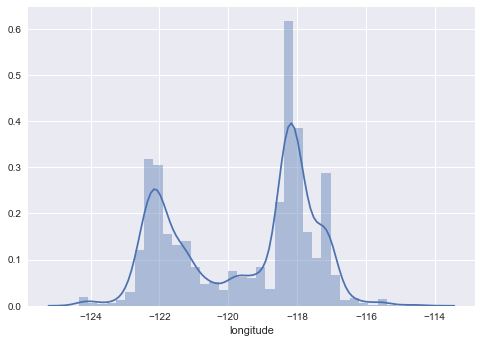

In [8]:
sns.distplot(data['longitude'])
plt.show()

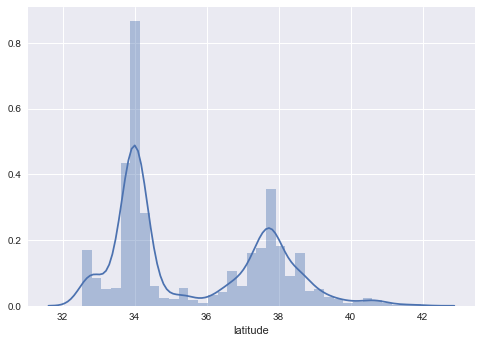

In [9]:
sns.distplot(data['latitude'])
plt.show()

In [10]:
print("latitude min",data["latitude"].min())
print("latitude max value",data["latitude"].max())

print("longitude min", data["longitude"].min())
print("longitude max value",data["longitude"].max())

latitude min 32.54
latitude max value 41.95
longitude min -124.35
longitude max value -114.31


In [ ]:
# Checking the age distribution of the DF

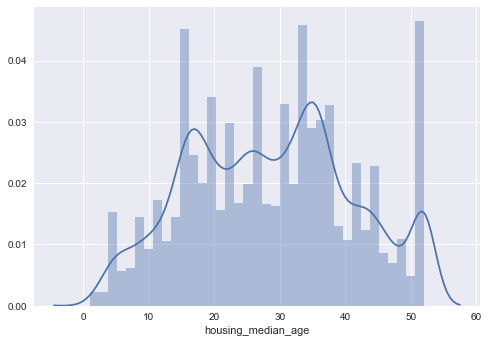

In [11]:
sns.distplot(data['housing_median_age'])
plt.show()

# General observation : 
+ Data is not normally distributed so we will have to normalise the data. However, i am still curious to check the 
  skewnees of the entire dataframe

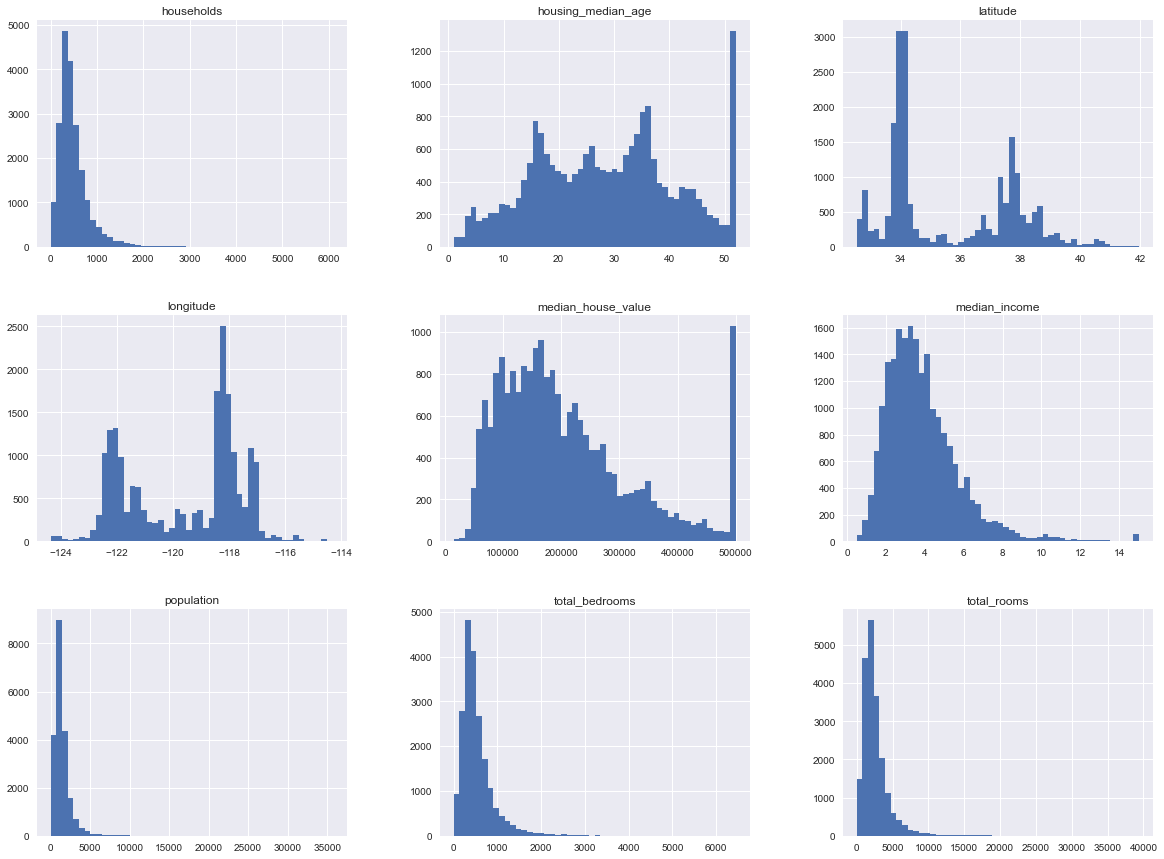

In [12]:
data.hist(bins=50, figsize=(20,15))
# save_fig("attribute_histogram_plots")
plt.show()